In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

# Lesson 63 - Intro to Classification

#### Multi-class vs Multi-label classification

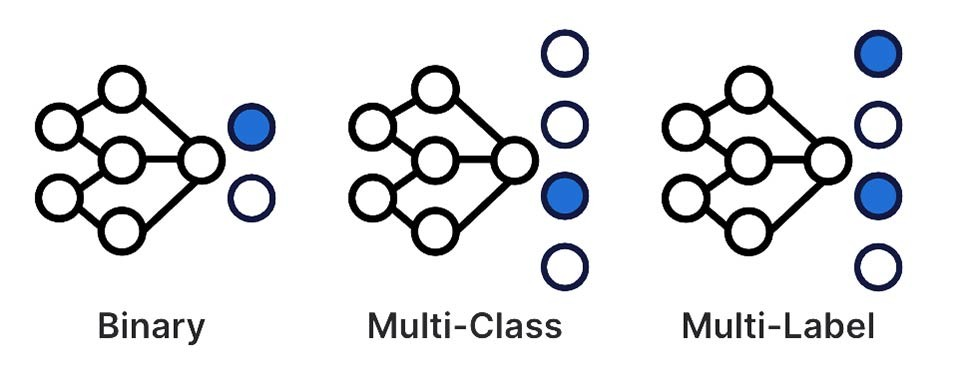

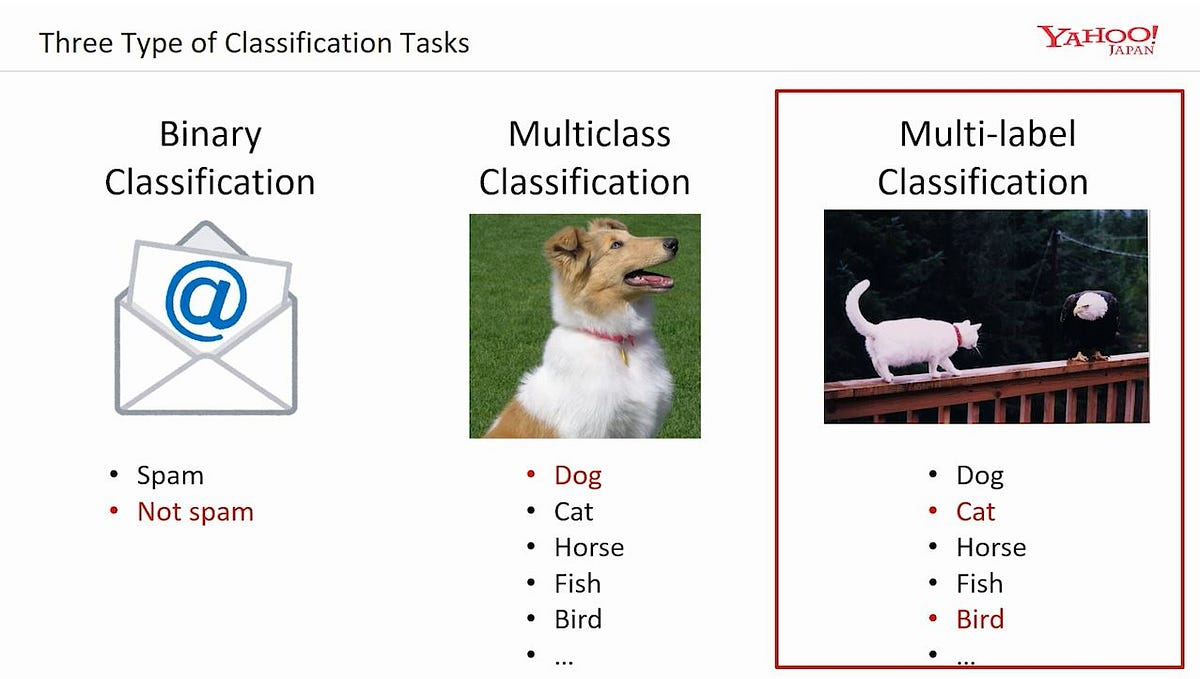

# Lesson 64+65 - Architecture of a Classification model

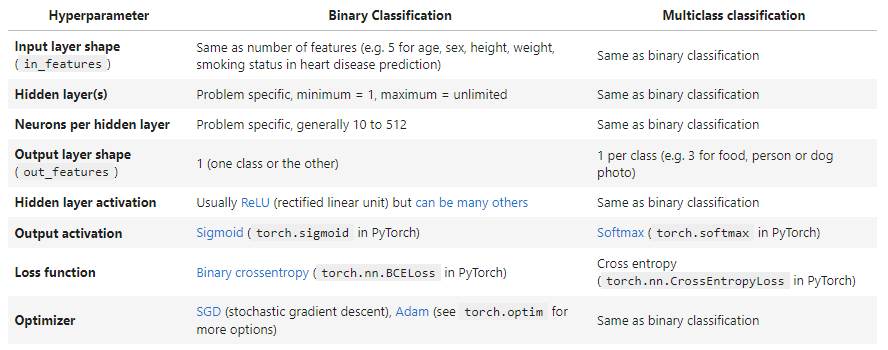

In [2]:
# making data

from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
 X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

- 2 features of X relates to 1 label of y

In [6]:
# making dataframe

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

In [7]:
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [8]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

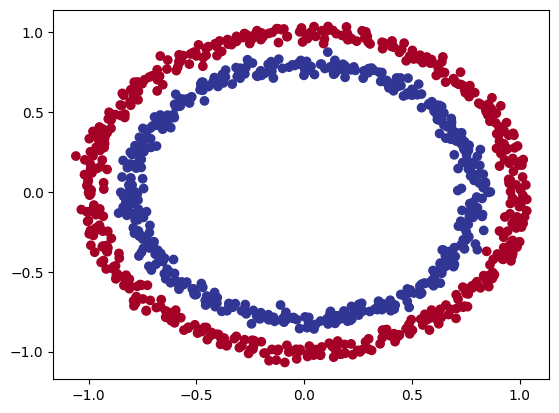

In [9]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap= plt.cm.RdYlBu )

### Converting data into tensors

In [10]:
X.shape, y.shape

((1000, 2), (1000,))

2 features

y is a scalar as it only has 1 value

In [11]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [12]:
X = torch.from_numpy(X).type(torch.float)


In [13]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [14]:
y = torch.from_numpy(y).type(torch.float)

In [15]:
y[:10]

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])

In [16]:
# train test split

from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
len(X_train), len(X_test)

(800, 200)

# Lesson 68 - Building Classification Model

### making device agnostic code

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

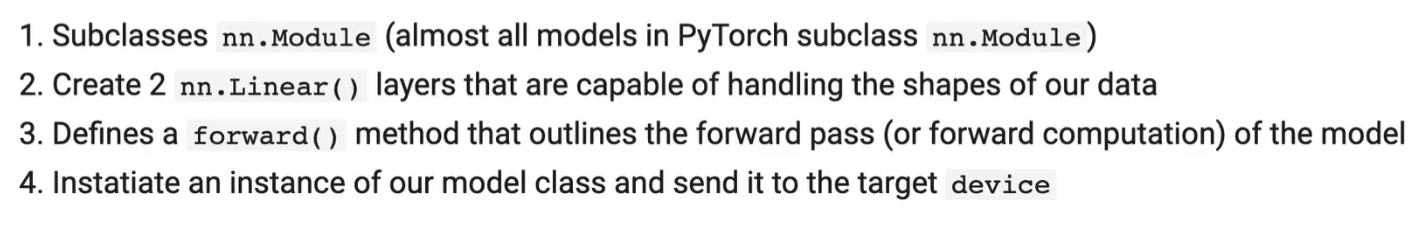

In [20]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 nn.Linear Layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # generally no of nuerons are multiple of 8
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

    # 3. defining forward computation
  def forward(self, x):
    return self.layer_2(self.layer_1(x))


# instantiating instance of model class  AND SENDING IT TO TARGET DEVICE
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
# where are parameters stored
next(model_0.parameters()).device

device(type='cuda', index=0)

- we can also use `nn.Sequential()` to instantiate our model class, but subclassing can help create more complex models

In [22]:
# making model using nn.Sequential()


# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 nn.Linear Layers
    self.two_linear_layers = nn.Sequential(
      nn.Linear(in_features=2, out_features=5), # generally no of nuerons are multiple of 8
      nn.Linear(in_features=5, out_features=1)
    )

    # 3. defining forward computation
  def forward(self, x):
    return two_linear_layers(x)


# instantiating instance of model class  AND SENDING IT TO TARGET DEVICE
model_1 = CircleModelV0().to(device)
model_1

# this is the exact same model


CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [23]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.1012, -0.2133],
                      [ 0.7033, -0.0360],
                      [ 0.0456, -0.2236],
                      [ 0.5395, -0.0266],
                      [-0.3432, -0.4347]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.1847,  0.5460, -0.1118, -0.5641,  0.6143], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1198, -0.2606,  0.3796,  0.3987, -0.0371]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.4098], device='cuda:0'))])

- 10 weights bc 2x5=10
- 5 biases bc 5 nerons in hidden layer

In [24]:
# making predictions without training model

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))


untrained_preds[:10]

tensor([[-0.9132],
        [-0.9108],
        [-0.8421],
        [-0.9336],
        [-0.7194],
        [-0.7189],
        [-0.8094],
        [-0.7642],
        [-0.8474],
        [-0.9093]], device='cuda:0')

In [25]:
y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

## Setting up loss function and optimizer

In [26]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [27]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## Training Model

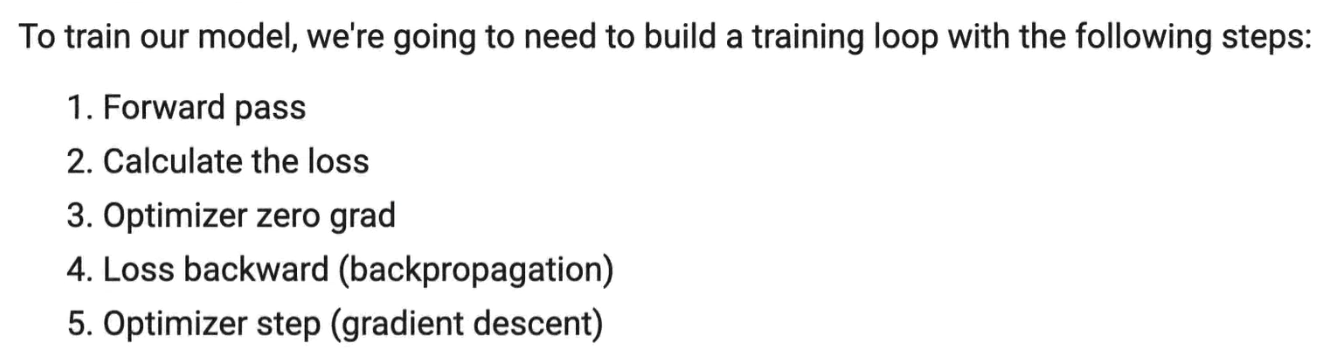

In [28]:
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

- Raw output of model is logit
- we can convert our raw output into probabilities by using activation functions

In [29]:
# finding untrained predictions again (y_logits)

model_0.eval()

with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

y_logits

tensor([[-0.9132],
        [-0.9108],
        [-0.8421],
        [-0.9336],
        [-0.7194]], device='cuda:0')

In [30]:
# applying sigmoid on logits

y_untrained_preds_sigmoid = torch.sigmoid(y_logits)

y_untrained_preds_sigmoid

tensor([[0.2863],
        [0.2868],
        [0.3011],
        [0.2822],
        [0.3275]], device='cuda:0')

In [31]:
torch.round(y_untrained_preds_sigmoid)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

# Lesson 74 - Building Training Loop

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs ->pred labels

  # Calculating loss + Accuracy / we can see multiple metrics during training
  loss = loss_fn(y_logits, #nn.BCEwithlogitsLoss
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backprop)
  loss.backward()

  # Optimizer step
  optimizer.step()

  #testing
  with torch.inference_mode():

    #forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # printing out what's happening
  if epoch %10==0:
    print(f"Epoch {epoch} | Loss: {loss} | accuracy {acc} | test loss {test_loss} | test accuracy {test_acc}")

Epoch 0 | Loss: 0.7756854295730591 | accuracy 50.0 | test loss 0.7665206789970398 | test accuracy 50.0
Epoch 10 | Loss: 0.7213367819786072 | accuracy 50.0 | test loss 0.7167851328849792 | test accuracy 50.0
Epoch 20 | Loss: 0.7041792273521423 | accuracy 50.0 | test loss 0.7004969716072083 | test accuracy 50.0
Epoch 30 | Loss: 0.6984957456588745 | accuracy 47.875 | test loss 0.6948778629302979 | test accuracy 47.5
Epoch 40 | Loss: 0.6964951753616333 | accuracy 46.0 | test loss 0.692852258682251 | test accuracy 49.0
Epoch 50 | Loss: 0.6957038640975952 | accuracy 47.5 | test loss 0.6920926570892334 | test accuracy 50.0
Epoch 60 | Loss: 0.6953212022781372 | accuracy 48.625 | test loss 0.6918030977249146 | test accuracy 49.0
Epoch 70 | Loss: 0.6950852870941162 | accuracy 48.25 | test loss 0.6917001008987427 | test accuracy 52.0
Epoch 80 | Loss: 0.6949087381362915 | accuracy 48.75 | test loss 0.6916771531105042 | test accuracy 52.5
Epoch 90 | Loss: 0.6947616338729858 | accuracy 48.375 | test

# Making predictions and evaluating the model

In [33]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f: # create  a file helper_functions.py with write permissions
    f.write(request.content) # write in the file the content of the requests


from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


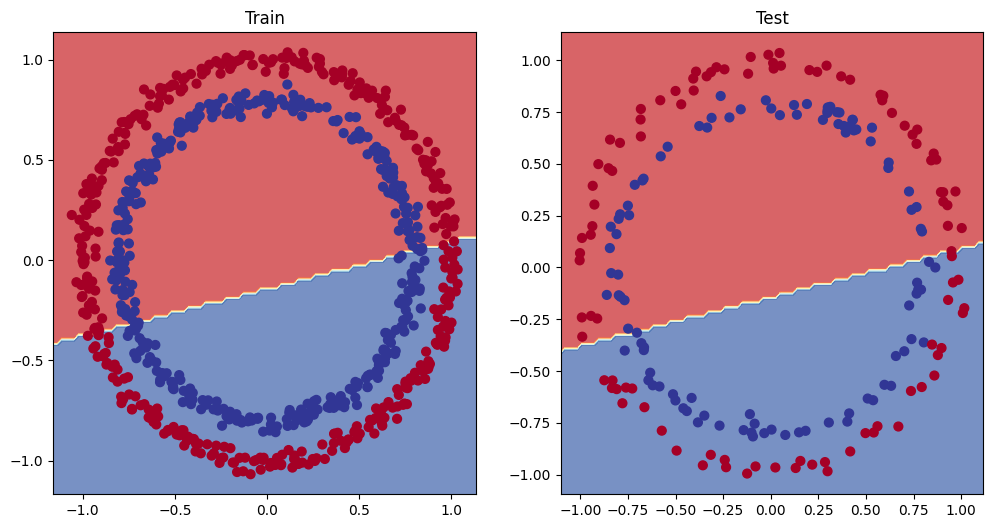

In [34]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1) # rows, #total_plots, column
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


This is because the model is only made of linear layers

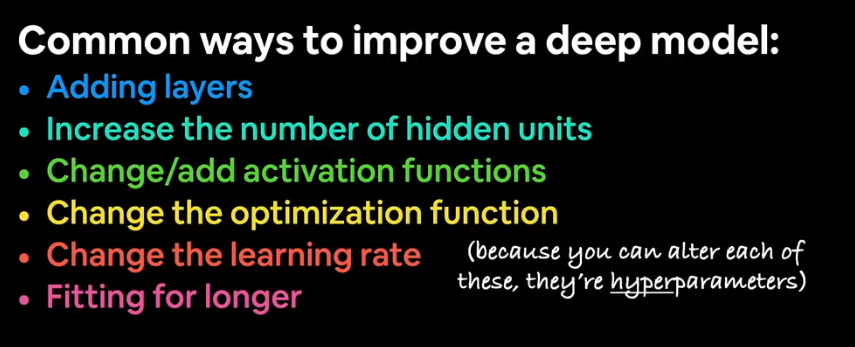

These are hyperparameters

# Lesson 77: Improving our model

continuing frpm 83 - relu is important

just adding relu

In [38]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 nn.Linear Layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # generally no of nuerons are multiple of 8
    self.layer_2 = nn.Linear(in_features=5, out_features=1)
    self.relu = nn.ReLU()

    # 3. defining forward computation
  def forward(self, x):
    return self.layer_2(self.relu(self.layer_1(x)))


# instantiating instance of model class  AND SENDING IT TO TARGET DEVICE
model_2 = CircleModelV1().to(device)
model_2


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()

  # forward pass
  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs ->pred labels

  # Calculating loss + Accuracy / we can see multiple metrics during training
  loss = loss_fn(y_logits, #nn.BCEwithlogitsLoss
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backprop)
  loss.backward()

  # Optimizer step
  optimizer.step()

  #testing
  with torch.inference_mode():

    #forward pass
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # printing out what's happening
  if epoch %10==0:
    print(f"Epoch {epoch} | Loss: {loss} | accuracy {acc} | test loss {test_loss} | test accuracy {test_acc}")

Epoch 0 | Loss: 0.6975250244140625 | accuracy 50.0 | test loss 0.6982601881027222 | test accuracy 50.0
Epoch 10 | Loss: 0.6965391635894775 | accuracy 50.0 | test loss 0.6975403428077698 | test accuracy 50.0
Epoch 20 | Loss: 0.6959988474845886 | accuracy 50.0 | test loss 0.6970788240432739 | test accuracy 50.0
Epoch 30 | Loss: 0.6956164240837097 | accuracy 40.375 | test loss 0.6966755390167236 | test accuracy 36.0
Epoch 40 | Loss: 0.6952919363975525 | accuracy 38.0 | test loss 0.6962804794311523 | test accuracy 36.0
Epoch 50 | Loss: 0.6949961185455322 | accuracy 41.125 | test loss 0.6958866119384766 | test accuracy 42.5
Epoch 60 | Loss: 0.6947134137153625 | accuracy 41.875 | test loss 0.6954943537712097 | test accuracy 43.5
Epoch 70 | Loss: 0.6944400072097778 | accuracy 42.25 | test loss 0.6951072812080383 | test accuracy 44.0
Epoch 80 | Loss: 0.6941717863082886 | accuracy 43.125 | test loss 0.6947243809700012 | test accuracy 45.5
Epoch 90 | Loss: 0.69390469789505 | accuracy 44.125 | te

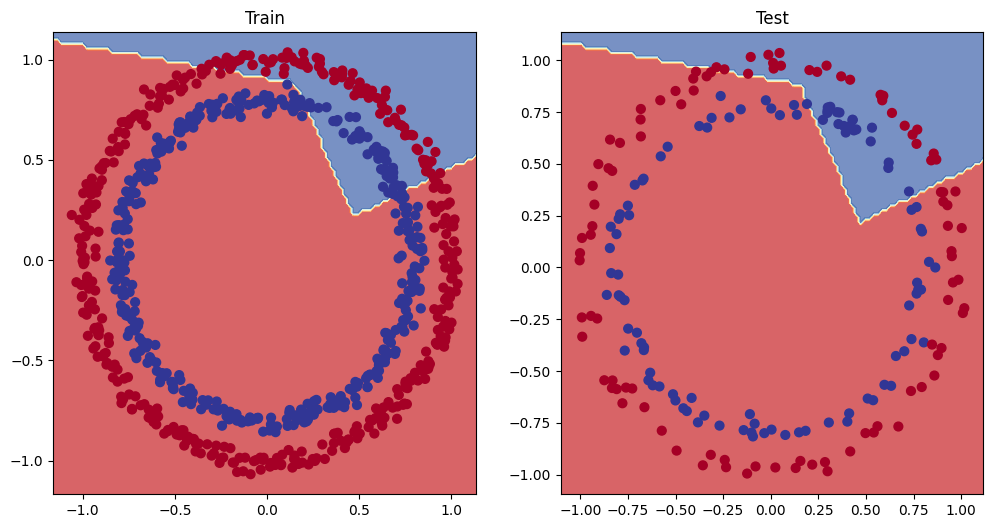

In [40]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1) # rows, #total_plots, column
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)


Improving model by:
1. adding more neurons in hidden layer 5->10
2. increasing number of hidden layers 2->3
3. increasing number of epochs 100->1000

In [41]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 nn.Linear Layers
    self.layer_1 = nn.Linear(in_features=2, out_features=10) # generally no of nuerons are multiple of 8
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

    # 3. defining forward computation
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


# instantiating instance of model class  AND SENDING IT TO TARGET DEVICE
model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [42]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  # forward pass
  y_logits = model_3(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs ->pred labels

  # Calculating loss + Accuracy / we can see multiple metrics during training
  loss = loss_fn(y_logits, #nn.BCEwithlogitsLoss
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backprop)
  loss.backward()

  # Optimizer step
  optimizer.step()

  #testing
  with torch.inference_mode():

    #forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # printing out what's happening
  if epoch %10==0:
    print(f"Epoch {epoch} | Loss: {loss} | accuracy {acc} | test loss {test_loss} | test accuracy {test_acc}")

Epoch 0 | Loss: 0.6929463148117065 | accuracy 50.0 | test loss 0.6931881308555603 | test accuracy 50.0
Epoch 10 | Loss: 0.6924761533737183 | accuracy 50.5 | test loss 0.6925959587097168 | test accuracy 50.0
Epoch 20 | Loss: 0.6922457218170166 | accuracy 59.12500000000001 | test loss 0.6923112273216248 | test accuracy 56.49999999999999
Epoch 30 | Loss: 0.6920924186706543 | accuracy 70.25 | test loss 0.6921225786209106 | test accuracy 68.0
Epoch 40 | Loss: 0.6919483542442322 | accuracy 68.375 | test loss 0.6919480562210083 | test accuracy 71.0
Epoch 50 | Loss: 0.6918084025382996 | accuracy 58.25 | test loss 0.6917727589607239 | test accuracy 57.99999999999999
Epoch 60 | Loss: 0.6916753053665161 | accuracy 54.0 | test loss 0.691611647605896 | test accuracy 54.50000000000001
Epoch 70 | Loss: 0.691547691822052 | accuracy 53.125 | test loss 0.6914635300636292 | test accuracy 53.0
Epoch 80 | Loss: 0.6914128065109253 | accuracy 52.625 | test loss 0.6913154721260071 | test accuracy 53.0
Epoch 9

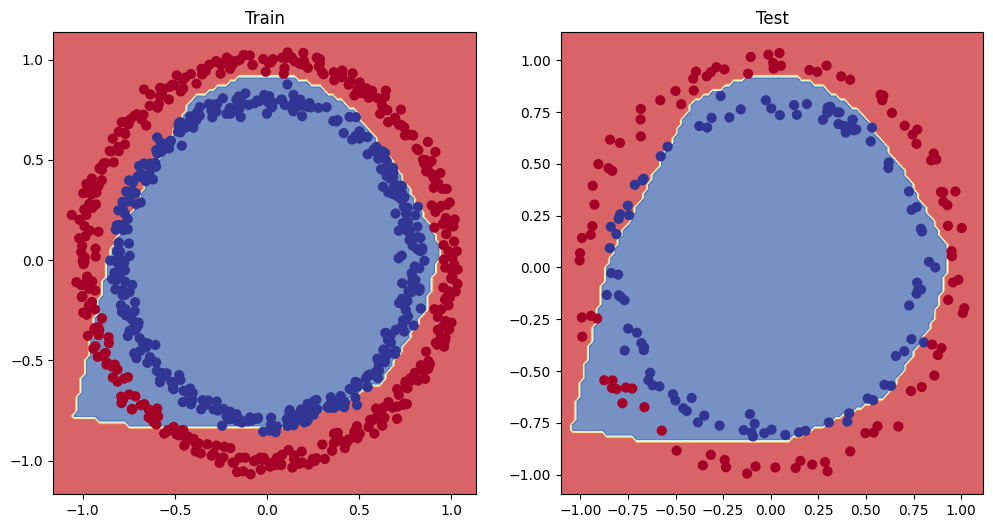

In [44]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1) # rows, #total_plots, column
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

Adding 2 more hidden and increasing neurons to 64

In [47]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Creating 2 nn.Linear Layers
    self.layer_1 = nn.Linear(in_features=2, out_features=64) # generally no of nuerons are multiple of 8
    self.layer_2 = nn.Linear(in_features=64, out_features=128)
    self.layer_3 = nn.Linear(in_features=128, out_features=128)
    self.layer_4 = nn.Linear(in_features=128, out_features=64)
    self.layer_5 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()

    # 3. defining forward computation
  def forward(self, x):
    return self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))


# instantiating instance of model class  AND SENDING IT TO TARGET DEVICE
model_4 = CircleModelV3().to(device)
model_4


CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=64, bias=True)
  (layer_5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [48]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_4.train()

  # forward pass
  y_logits = model_4(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs ->pred labels

  # Calculating loss + Accuracy / we can see multiple metrics during training
  loss = loss_fn(y_logits, #nn.BCEwithlogitsLoss
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_preds)

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss backward (backprop)
  loss.backward()

  # Optimizer step
  optimizer.step()

  #testing
  with torch.inference_mode():

    #forward pass
    test_logits = model_4(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # printing out what's happening
  if epoch %10==0:
    print(f"Epoch {epoch} | Loss: {loss} | accuracy {acc} | test loss {test_loss} | test accuracy {test_acc}")

Epoch 0 | Loss: 0.6944466233253479 | accuracy 50.0 | test loss 0.6944223046302795 | test accuracy 50.0
Epoch 10 | Loss: 0.6934258341789246 | accuracy 50.0 | test loss 0.693554162979126 | test accuracy 50.0
Epoch 20 | Loss: 0.6929086446762085 | accuracy 50.0 | test loss 0.6931390166282654 | test accuracy 50.0
Epoch 30 | Loss: 0.6925826668739319 | accuracy 55.00000000000001 | test loss 0.6928926706314087 | test accuracy 54.50000000000001
Epoch 40 | Loss: 0.6923277974128723 | accuracy 53.25 | test loss 0.6927131414413452 | test accuracy 51.0
Epoch 50 | Loss: 0.692021906375885 | accuracy 59.75 | test loss 0.6924900412559509 | test accuracy 53.0
Epoch 60 | Loss: 0.6917990446090698 | accuracy 58.5 | test loss 0.6923550963401794 | test accuracy 52.0
Epoch 70 | Loss: 0.6915998458862305 | accuracy 57.125 | test loss 0.6922250390052795 | test accuracy 52.0
Epoch 80 | Loss: 0.6914028525352478 | accuracy 58.12500000000001 | test loss 0.6921072006225586 | test accuracy 52.0
Epoch 90 | Loss: 0.69119

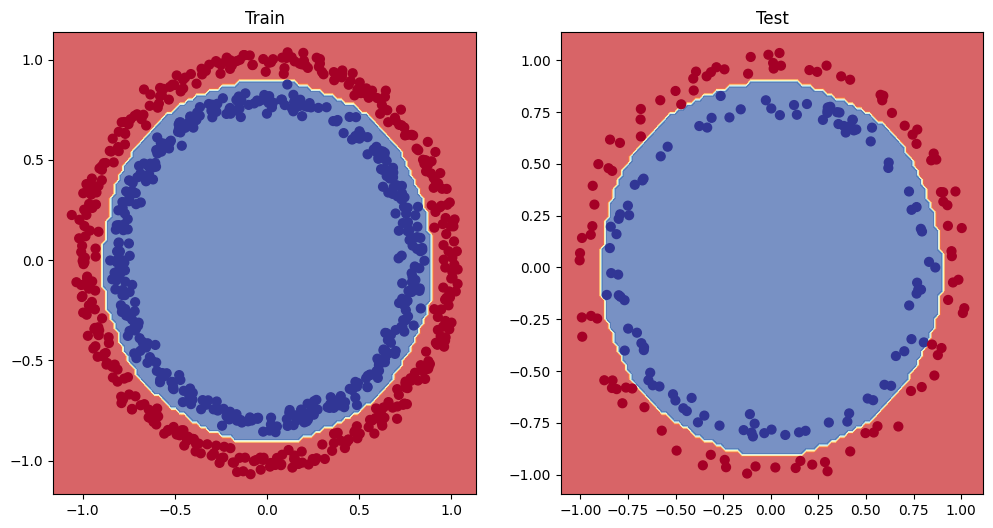

In [49]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1) # rows, #total_plots, column
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)